# Catboost Modelling

In this notebook, a final sales forecasting model based on the CatBoost algorithm is created. More information can be found here: https://catboost.ai/

Just as the Random Forest model, the final model is also a tree-based model. These types of algorithms lend themselves well to predicting target features that are not normally distributed, as is the case with sales here. Moreover, CatBoost is specifically tailored to datasets with many categorical variables. With the expception of weather and lag variables, this dataset mainly contains categorical features, including dummy variables.

Given the flexibility of CatBoost, no additional preprocessing is necessary. It can handle object (categorical) variables, missing values and responds well to non-normally distributed target variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.patches import Patch
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import OneHotEncoder, RobustScaler, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import sktime

from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from statsmodels.tsa.stattools import adfuller

from catboost import CatBoostRegressor
import catboost as cb
import optuna

In [2]:
#sktime libraries

from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows, plot_series
from sktime.transformations.series.summarize import WindowSummarizer

In [5]:
# for google colab
#!unrar x drive/MyDrive/sweet-spot-donut-sales-forecasting.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from drive/MyDrive/sweet-spot-donut-sales-forecasting.rar

Extracting  functions_model.py                                             0%  OK 
Extracting  functions_vis.py                                               0%  OK 
Extracting  train_df.csv                                                  99%  OK 
Extracting  test_df.csv                                                  100%  OK 
All OK


In [3]:
! jupyter nbextension enable widgetsnbextension --py

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [4]:
%run functions_model.py
%run functions_vis.py

In [5]:
pd.set_option("display.max_columns", None)

### Loading the dataset

In [6]:
d = pd.read_csv("data/train_df.csv")
d_test = pd.read_csv("data/test_df.csv")

In [7]:
d['date'] = pd.to_datetime(d['date'])
d_test['date'] = pd.to_datetime(d_test['date'])

## Modelling

#### Selecting features

In order for the CatBoost algorithm to recognize categorical features, all variables are saved either as categorical or numerical. The date variable will serve as the index, while the lag features will only be used in the training and validation, but not the test dataset.

In [10]:
date = ["date"]

catfeat = ["store_name","item_category",'box_deal', 'day', 'halloween', 'hol_pub', 'hol_school',
       'month', 'nye', 'public_space', 'street_market', 'valentines_day','week_year', 'weekday', 'year']

numfeat = ["days_back","temperature_2m_mean","sunshine_duration","precipitation_hours"]

lag = ["lag1","lag2"]

Two types of sets were created:

1. The first type of train, validation and test datasets contains all features at the day, store and product level.
2. The second type contains all features only at the day and store level. The different product categories were removed and **only total daily sales** per store are kept.

In [ ]:
x_train = d[date + catfeat + numfeat + lag]
x_train = x_train.set_index("date")
x_train_daily = x_train[(x_train["item_category"] == "daily total")].drop("item_category", axis = 1)
y_train = d['total_amount']
y_train_daily = d[(d["item_category"] == "daily total")]['total_amount']

#x_val = val[date + catfeat + numfeat + lag]
#x_val = x_val.set_index("date")
#x_val_daily = x_val[(x_val["item_category"] == "daily total")].drop("item_category", axis = 1)
#y_val = val['total_amount']
#y_val_daily = val[(val["item_category"] == "daily total") ]['total_amount']

x_test = d_test[date + catfeat + numfeat]
x_test = x_test.set_index("date")
x_test_daily = x_test[(x_test["item_category"] == "daily total")].drop("item_category", axis = 1)
y_test = d_test['total_amount']
y_test_daily = d_test[(d_test["item_category"] == "daily total")]['total_amount']

In [ ]:
#catfeat.remove("item_category")

#### Converting holiday features to integer

In [ ]:
x_train["hol_pub"] = x_train["hol_pub"].apply(np.int64)
x_train["hol_school"] = x_train["hol_school"].apply(np.int64)
x_train_daily["hol_pub"] = x_train_daily["hol_pub"].apply(np.int64)
x_train_daily["hol_school"] = x_train_daily["hol_school"].apply(np.int64)

x_val["hol_pub"] = x_val["hol_pub"].apply(np.int64)
x_val["hol_school"] = x_val["hol_school"].apply(np.int64)
x_val_daily["hol_pub"] = x_val_daily["hol_pub"].apply(np.int64)
x_val_daily["hol_school"] = x_val_daily["hol_school"].apply(np.int64)

x_test["hol_pub"] = x_test["hol_pub"].apply(np.int64)
x_test["hol_school"] = x_test["hol_school"].apply(np.int64)
x_test_daily["hol_pub"] = x_test_daily["hol_pub"].apply(np.int64)
x_test_daily["hol_school"] = x_test_daily["hol_school"].apply(np.int64)

The train and target variables are concatenated to obtain a train and test set at the daily sales level, without the individual product categories.

In [ ]:
train_daily = pd.concat([x_train_daily.reset_index(), y_train_daily.reset_index(drop= True)], axis = 1)

test_daily = pd.concat([x_test_daily.reset_index(), y_test_daily.reset_index(drop= True)], axis = 1)

### Hyperparameter Tuning with Cross-validation


Training tree-based algorithm often leads to overfitting. In order to create a generalizable model, it is necessary to "prune" the trees by putting constraints on how well they can learn from the data. The following hyperparameters are tuned in the step below:

* Number of trees
* Learning rate
* L2 leaf regularization
* Tree depth (number of levels)
* Proportion of the sample used for each tree
* Proportion of the features used for each tree
* A minimum amount of datapoints in a leaf before a split can occur
* Minimum child weight


In [11]:
d2 = d[date + catfeat + numfeat]
#d2 = d2[d2["item_category"] != "daily total"]
d2 = pd.concat([d2, d["total_amount"]], axis = 1)

d_test2 = d_test[date + catfeat + numfeat]
#d_test2 = d_test2[d_test2["item_category"] != "daily total"]
d_test2 = pd.concat([d_test2, d_test["total_amount"]], axis = 1)

In [12]:
agg_columns = d2.columns.difference(['date', 'store_name', 'item_category'] + ["total_amount"])
agg_dict = {col: "first" for col in agg_columns}
agg_dict["total_amount"] = "sum"

d2 = d2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d2["hol_pub"] = d2["hol_pub"].apply(np.int64)
d2["hol_school"] = d2["hol_school"].apply(np.int64)

d2 = d2.set_index(["store_name","item_category","date"]).sort_index()

d_test2 = d_test2.groupby(['date', 'store_name', 'item_category']).agg(agg_dict).reset_index().sort_values(by = "date", ascending = False).reset_index(drop = True)
d_test2["hol_pub"] = d_test2["hol_pub"].apply(np.int64)
d_test2["hol_school"] = d_test2["hol_school"].apply(np.int64)

d_test2 = d_test2.set_index(["store_name","item_category","date"]).sort_index()

In [13]:
kwargs = {"lag_feature": {
    "lag":[1,2,3],
    "mean": [[1,7], [1, 15], [1,30]],
    "std": [[1,4]]
    },
    "target_cols":["total_amount"]}

transformer = WindowSummarizer(**kwargs, n_jobs= -1)


In [14]:
d2wind = transformer.fit_transform(d2)

In [22]:
d2wind = pd.concat([d2["total_amount"], d2wind], axis = 1).dropna()

### Creating validation dataset
A validation set, containing the last 7 days of the entire training dataset, is created. The validation set is used for evaluation purposes and early stopping in the CatBoost model.

In [24]:
train, val = create_val_set(d2wind.reset_index())
train = train.set_index(["store_name","item_category","date"]).sort_index()
train = train.iloc[train.index.get_level_values("date") >= pd.to_datetime("2021-07-12")]
val = val.set_index(["store_name","item_category","date"]).sort_index()

for col in catfeat[2:]:
    train[col] = train[col].apply(np.int64)
    val[col] = val[col].apply(np.int64)

**Time-series cross-validation split**

When performing k-fold cross-validation in a time-series context, the data musn't be shuffled as in a regular cross-validation scenario. Instead, a forecasting horizon has to be defined for each fold, which serves as the validation set. It always comes after the training set chronologically. Because predicting donut sales for more than one week in advance is a difficult endeavor and will most likely lead to imprecise results, the forecasting horizon for this problem was set to 7 days.

The graph below depicts the time-series cross-validation process visually. The forecsasting horizon of 7 days from the first fold becomes part of the training set in the second cross-validation fold, while the next 7 days serve as the second validation set. Five folds were chosen in total, meaning there are 35 validation days on which the training data is evaluated.

</br>

**Note:**

---

When making time-series forecasting on a test dataset, predictions are often done recursively. This means that the model does not make predictions for all points in a forecasting horizon at once (7 days in this case), but does so day by day. The reason for that is that when window variables - such as lagged features or rolling averages of the target variable (donut sales) - are considered as explanatory variables, they won't actually exist in the test dataset. They are, in that case, calculated based on future target variable values which are yet to be predicted.

This type of assessment will be performed on the testing dataset at the end of the notebook . However, the cross-validation process in this case would not only involve recursive predictions, but would also have to accommodate hierarchical data structures (i.e. one store per one product per one day).

In order to simplify this task, no recursive predictions will be carried out on either of the five validation folds at this point. While this won't yield the most optimal predictions, performing time-series cross-validation can still produce good evaluation results.

To make the results more rigorous, recursive forecasting in cross-validation should be implemented in the future.

In [16]:
cv_list = window_splitter_prep(train, validation_length = 7, num_folds = 5)

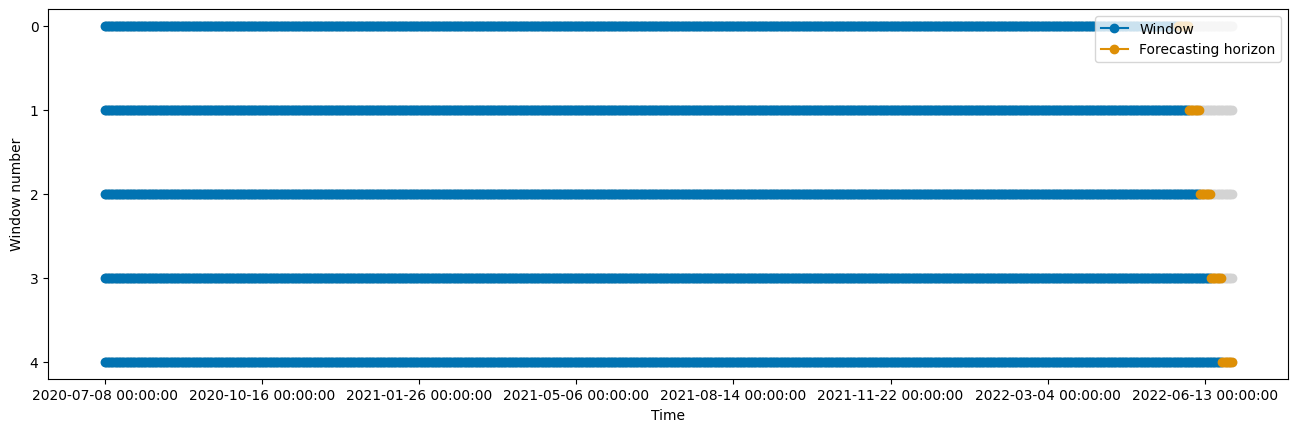

In [ ]:
for i in range(32,33):
    plot_windows(list(cv_list[i][0].values())[0], list(cv_list[i][1].values())[0]["total_amount"])

**Hyperparameter tuning**

Given that CatBoost is a tree-based model, there is a large number of hyperparameters that can be tuned. For this task, the following hyperparameters were chosen:

* Number of trees (estimators)
* Learning rate
* L2 leaf regularization
* Tree depth
* Percentage of datapoint to be used in each tree (bootstrapping)
* Percentage of features to be used in each tree
* Smallest number of data to be used in a leaf before a split is made

In [25]:
x_train = train.reset_index().drop("total_amount", axis = 1)
x_val = val.reset_index().drop("total_amount", axis = 1).set_index("date")
y_train = train.reset_index()[["date","total_amount"]]
y_val = val.reset_index()[["date","total_amount"]].set_index("date")

In [21]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 2, 30),
        "depth": trial.suggest_int("depth", 5, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "random_strength": trial.suggest_float("random_strength", 1, 10)
    }

    scores = []

    for train_idx, test_idx in create_train_validation_folds(x_train):
        X_train_fold, X_val_fold = x_train.iloc[train_idx], x_train.iloc[test_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        X_train_fold = X_train_fold.set_index("date")
        X_val_fold = X_val_fold.set_index("date")
        y_train_fold = y_train_fold.set_index("date")
        y_val_fold = y_val_fold.set_index("date")

        model = CatBoostRegressor(**params, loss_function = "RMSE", silent=True,
                                  allow_writing_files = False, task_type="GPU", bootstrap_type="Poisson")

        model.fit(X_train_fold, y_train_fold, eval_set = (x_val, y_val), early_stopping_rounds = 50, cat_features=catfeat)

        y_pred = model.predict(X_val_fold)

        score = mean_squared_error(y_val_fold, y_pred, squared=False)

        scores.append(score)

    return np.mean(scores)



In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 15)

[I 2024-08-09 12:53:09,751] A new study created in memory with name: no-name-ad675505-d989-4d1d-9418-a75f14091c47
[I 2024-08-09 12:53:35,574] Trial 0 finished with value: 380.6843682879291 and parameters: {'n_estimators': 349, 'learning_rate': 0.0002483207560796887, 'l2_leaf_reg': 4.145919312153844, 'depth': 6, 'subsample': 0.3544059934453484, 'min_data_in_leaf': 22, 'random_strength': 5.035693739511956}. Best is trial 0 with value: 380.6843682879291.
[I 2024-08-09 12:55:04,565] Trial 1 finished with value: 102.13504314288286 and parameters: {'n_estimators': 2793, 'learning_rate': 0.0948724560273695, 'l2_leaf_reg': 20.175788478590995, 'depth': 9, 'subsample': 0.3228633492949712, 'min_data_in_leaf': 93, 'random_strength': 4.688536316741192}. Best is trial 1 with value: 102.13504314288286.
[I 2024-08-09 13:07:17,779] Trial 2 finished with value: 132.9984826286046 and parameters: {'n_estimators': 2486, 'learning_rate': 0.0006600754006910011, 'l2_leaf_reg': 6.140286093816204, 'depth': 9, '

In [23]:
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

Best hyperparameters: {'n_estimators': 2793, 'learning_rate': 0.0948724560273695, 'l2_leaf_reg': 20.175788478590995, 'depth': 9, 'subsample': 0.3228633492949712, 'min_data_in_leaf': 93, 'random_strength': 4.688536316741192}
Best RMSE: 102.13504314288286


In [36]:
best_parameters = study.best_params
del best_parameters["n_estimators"]

In [27]:
x_train = x_train.set_index("date")
y_train = y_train.set_index("date")

In [25]:
best_parameters = {'learning_rate': 0.0948724560273695,
 'l2_leaf_reg': 20.175788478590995,
 'depth': 9,
 'subsample': 0.3228633492949712,
 'min_data_in_leaf': 93,
 'random_strength': 4.688536316741192}

model = CatBoostRegressor(**best_parameters, n_estimators = 3000, colsample_bylevel = 0.2, allow_writing_files = True, random_state=132)

model.fit(x_train, y_train, eval_set=(x_val, y_val),
          early_stopping_rounds = 200, 
          cat_features = catfeat, verbose = 250, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 450.7563240	test: 358.0336045	best: 358.0336045 (0)	total: 28.7ms	remaining: 1m 26s
250:	learn: 105.5182990	test: 100.4457517	best: 99.5056457 (222)	total: 13s	remaining: 2m 22s
500:	learn: 86.8551064	test: 97.7985297	best: 97.5798884 (374)	total: 27.6s	remaining: 2m 17s
750:	learn: 76.6222598	test: 95.8974236	best: 95.0378787 (643)	total: 42.2s	remaining: 2m 6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 95.03787872
bestIteration = 643

Shrink model to first 644 iterations.


In [28]:
best_parameters2 = {'learning_rate': 0.0302289424483556, 
                    'l2_leaf_reg': 17.454469359806595, 
                    'depth': 10, 
                    'subsample': 0.6081282597582008, 
                    'min_data_in_leaf': 35,
                    'random_strength': 4.799266038182125}

model2 = CatBoostRegressor(**best_parameters2, n_estimators = 3000, colsample_bylevel = 0.2, allow_writing_files = True, random_state=132)

model2.fit(x_train, y_train, eval_set=(x_val, y_val),
          early_stopping_rounds = 100, 
          cat_features = catfeat, verbose = 250, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 468.5545422	test: 375.5749764	best: 375.5749764 (0)	total: 182ms	remaining: 9m 6s
250:	learn: 136.7390636	test: 109.4574158	best: 109.4574158 (250)	total: 16.4s	remaining: 2m 59s
500:	learn: 113.5604186	test: 102.6324850	best: 102.5682087 (484)	total: 34s	remaining: 2m 49s
750:	learn: 101.0885130	test: 100.8970589	best: 100.8970589 (750)	total: 52.5s	remaining: 2m 37s
1000:	learn: 92.0843262	test: 99.7605356	best: 99.7136961 (997)	total: 1m 14s	remaining: 2m 29s
1250:	learn: 85.5344304	test: 99.3281930	best: 99.2391399 (1244)	total: 1m 38s	remaining: 2m 17s
1500:	learn: 80.2069334	test: 98.5834507	best: 98.1288584 (1461)	total: 1m 58s	remaining: 1m 58s
1750:	learn: 75.7428518	test: 97.9963920	best: 97.6982641 (1712)	total: 2m 18s	remaining: 1m 38s
2000:	learn: 71.7866070	test: 97.2481720	best: 97.2310491 (1939)	total: 2m 37s	remaining: 1m 18s
2250:	learn: 68.6085962	test: 97.4223497	best: 97.0101649 (2142)	total: 2m 57s	remaining: 59s
Stopped by overfitting detector  (200 ite

### Feature importances

<Axes: xlabel='Feature Id'>

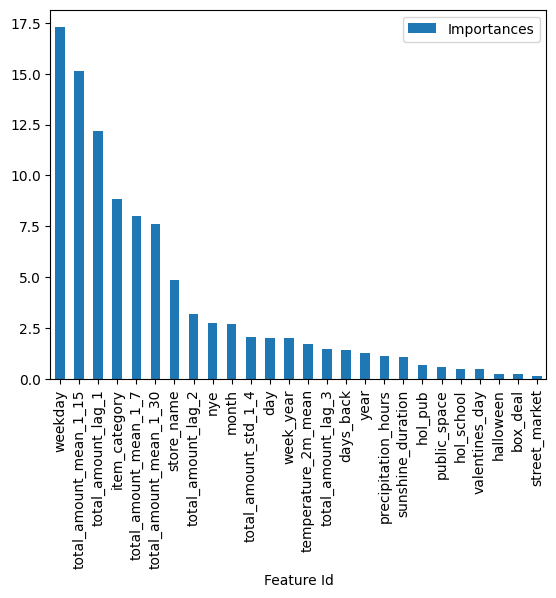

In [29]:
model2.get_feature_importance(prettified=True).plot(x = "Feature Id", y = "Importances", kind = "bar")

### Evaluation metrics train and validation set

In [26]:
y_train_pred = model.predict(x_train)
print(f"R-squared train: {round(r2_score(y_train, y_train_pred),6)}")
print(f"MAPE train: {round(100*mean_absolute_percentage_error(y_train, y_train_pred),2)}\n")

y_val_pred = model.predict(x_val)
print(f"R-squared validation: {round(r2_score(y_val, y_val_pred),6)}")
print(f"MAPE validation: {round(100*mean_absolute_percentage_error(y_val, y_val_pred),2)}")

R-squared train: 0.97057
MAPE train: 21.09

R-squared validation: 0.934951
MAPE validation: 25.41


In [30]:
y_train_pred2 = model2.predict(x_train)
print(f"R-squared train: {round(r2_score(y_train, y_train_pred2),6)}")
print(f"MAPE train: {round(100*mean_absolute_percentage_error(y_train, y_train_pred2),2)}\n")

y_val_pred2 = model2.predict(x_val)
print(f"R-squared validation: {round(r2_score(y_val, y_val_pred2),6)}")
print(f"MAPE validation: {round(100*mean_absolute_percentage_error(y_val, y_val_pred2),2)}")

R-squared train: 0.975638
MAPE train: 18.97

R-squared validation: 0.932223
MAPE validation: 23.13


# Test dataset

In [32]:
train_final = d2wind.iloc[d2wind.index.get_level_values("date") >= pd.to_datetime("2021-07-12")].reset_index().set_index("date")
x_train_final = train_final.reset_index().set_index("date").drop("total_amount", axis = 1)
y_train_final = train_final.reset_index().set_index("date")["total_amount"]

x_test_final = d_test2.reset_index().set_index("date").drop("total_amount", axis = 1)
y_test_final = d_test2.reset_index()[["date","total_amount"]].set_index("date")

The prediction of sales was done recursively, meaning that every day's sales in the test dataset was done separately. Put differently, sales, lagged and window variables (e.g. rolling averages) were predicted only for the next day. Predictions were thereby used iteratively as inputs for window variables, which rely on the target variables predicted values. 

The final result of this are more accurate sales prediction in the test dataset.

In [35]:
x_test_final, y_test_pred = pred_test(train = train_final, test = x_test_final, model = model2)

S:\Repos\sweet-spot-donut-sales-forecasting\functions_model.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.loc[:, "total_amount_lag_1"] = lag_value
S:\Repos\sweet-spot-donut-sales-forecasting\functions_model.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.loc[:, "total_amount_lag_2"] = lag_value2
S:\Repos\sweet-spot-donut-sales-forecasting\functions_model.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

### Residuals by store

In [46]:
diff_overview(data = d_test2.reset_index(), pred = y_test_pred, stores = all)

TypeError: '<' not supported between instances of 'int' and 'Timestamp'

In [37]:
difference_df = diff_overview(data = d_test2.reset_index(), pred = y_test_pred, stores = all)

KeyError: 'total_amount'

### Residual Plot Analysis

In [ ]:
sns.scatterplot(data = difference_df, x = "Predicted", y = "Stand_resid")

plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales (Daily total)")
plt.ylabel("Standardized Residuals")

plt.show()

### Evaluation metrics train and test set

In [ ]:
fit_overview(ytrain = y_train_daily, ytrainpred = y_train_pred, ytest = y_test_daily, ytestpred = y_test_pred)

In [ ]:
mape_stores(test_daily, y_test_pred)

### Visualisation of predictions

In [ ]:
df_predicted = pd.concat(
    [
    difference_df[["Date","Store name","Observed","Predicted"]].rename(columns = {"Date":"date","Store name":"store_name","Observed":"total_amount"}),
    d[(d["date"] >= pd.to_datetime("2024-05-01")) & (d["item_category"] == "daily total")][["date","store_name","total_amount"]]
    ]
    )

In [ ]:
ts_predicted(df_predicted)

In [ ]:
def create_train_validation_dataset(df):
    last_val_date = df.date.max()
    cv = []
    for n in range(5):
        first_val_date = last_val_date - dt.timedelta(days=6)
        train_fold = df[df.date<first_val_date]
        val_fold = df[(df.date>=first_val_date) & (df.date<=last_val_date)]
        cv.append((train_fold,val_fold))
        last_val_date = first_val_date - dt.timedelta(days=1)
    cv = cv[::-1]
    return cv

In [ ]:
for i in range(5):
  globals()[f"train_{i}"], globals()[f"val_{i}"] = create_train_validation_dataset(train_daily)[i]